In [1]:
import os
import numpy as np

import torch as th
from torch.utils.data import DataLoader, Dataset
import torchvision as tv
from torchvision import datasets, transforms
# from safetensors.torch import save_model, load_model

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

from typing import List, Union, Callable, Tuple
from torch import Tensor

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# # Constant hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 32	# Batch size for training
# TEST_BS: int = 1024	# Batch size for testing
EPOCHS: int = 40	# Number of epochs

# Hyperparameters
# TRAIN_BATCH_SIZE: int = 64
# TEST_BATCH_SIZE: int = 1000
# EPOCHS: int = 15
CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 2e-3



In [2]:
# Device setup
device: th.device = th.device(
    "mps" if th.backends.mps.is_available() and DEVICE_AUTODETECT else "cpu"
)

In [3]:
th.manual_seed(42)

In [4]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),           
])

train_dir = 'datasets/cleaned/Training'

# Original dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# New dataset
class CombinedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        # doubling lenght
        return len(self.original_dataset) * 2

    def __getitem__(self, idx):
        original_idx = idx // 2
        if idx % 2 == 0:
            # Original
            image, label = self.original_dataset[original_idx]
        else:
            # Horizontal flip
            image, label = self.original_dataset[original_idx]
            image = transforms.functional.rotate(image, angle=10)
            image = transforms.functional.affine(image, angle=0, translate=(int(0.002 * image.shape[1]), int(0.002 * image.shape[2])), scale=1.0, shear=12.5)
            image = transforms.functional.adjust_brightness(image, brightness_factor=1.15)
            image = transforms.functional.hflip(image)

        return image, label

combined_dataset = CombinedDataset(train_dataset)

# DataLoader
train_loader = DataLoader(combined_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

for images, labels in train_loader:
    print("Shape of batch images:", images.shape)
    print("Shape of batch labels:", labels.shape)
    break

Shape of batch images: torch.Size([32, 3, 150, 150])
Shape of batch labels: torch.Size([32])


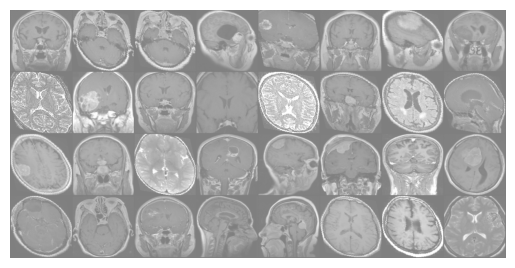

3 3 3 1 0 3 1 0 2 1 3 3 2 3 2 0 1 3 2 0 1 1 2 1 0 3 0 2 1 2 2 2


In [5]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(tv.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

In [6]:
class CNN_Gus(th.nn.Module):
    def __init__(self, cls_out: int = 4) -> None:
        super().__init__()

        self.conv = th.nn.Sequential(
            th.nn.Conv2d( # convolutional 1
                in_channels=3, out_channels=32, kernel_size=4, stride=1, padding=0
            ),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=3), # max pooling 1
            th.nn.Conv2d( # convolutional 2
                in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=0
            ),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=3), # max pooling 2
            th.nn.Conv2d( # convolutional 3
                in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0
            ),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=3), # max pooling 3
            th.nn.Conv2d( # convolutional 4
                in_channels=128, out_channels=128, kernel_size=4, stride=1, padding=0
            ),
            th.nn.ReLU(),
            th.nn.Flatten(),
        )

        self.head = th.nn.Sequential(
            th.nn.Linear(128, 512),
            th.nn.ReLU(),
            th.nn.Dropout(p=0.5),
            th.nn.Linear(512, cls_out),
            th.nn.Softmax(dim=1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.head(self.conv(x))


In [7]:
model: CNN_Gus = CNN_Gus().to(device)
model.train()

CNN_Gus(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=4, bias=True)
    (4): Softmax(dim=1)
  )
)

In [8]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=0.001, betas=(0.869, 0.995), eps=1e-7, weight_decay=0.005
)

In [9]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)


Training epoch: 100%|██████████| 40/40 [1:04:07<00:00, 96.18s/it] 


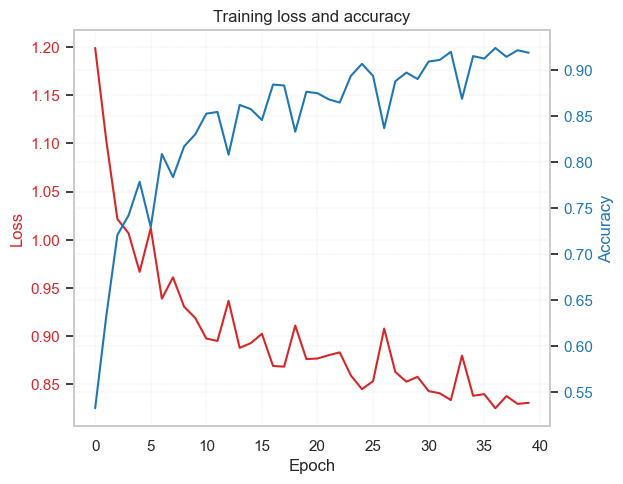

In [10]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [11]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.8309353691857068
Final training accuracy: 0.9188550420168067
